Daily Minimum Temperature dataset collected in Melbourne, Australia, available on Kaggle\footnote{\url{https://www.kaggle.com/datasets/paulbrabban/daily-minimum-temperatures-in-melbourne}}

In [ ]:
import pandas as pd

# ------------------ Load dataset directly from online GitHub source ------------------
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)

# ------------------ Convert 'Date' column to datetime format -------------------------
df['Date'] = pd.to_datetime(df['Date'])

# ------------------ Set 'Date' as index ----------------------------------------------
df.set_index('Date', inplace=True)

# ------------------ Check and handle missing values ----------------------------------
print("Missing values:\n", df.isna().sum())
df['Temp'].ffill(inplace=True)

# ------------------ Save to CSV (optional) -------------------------------------------
df.to_csv("Melbourne_Min_Temp_1981_1990.csv")

# ------------------ Preview the data -------------------------------------------------
print(df.head())


Melbourne Minimum Temperature Data Preprocessing

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# ----------- Load temperature data from GitHub ------------------
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df['Temp'].ffill(inplace=True)

# ----------- Normalize to [0, 1] ------------------
scaler = MinMaxScaler()
df['Temp_scaled'] = scaler.fit_transform(df[['Temp']])

# ----------- Create sliding window sequences ------------------
def create_sequences(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

X_temp, y_temp = create_sequences(df['Temp_scaled'].values, window_size=30)

# ----------- Split into train (70%), val (15%), test (15%) ---------------
n = len(X_temp)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train_temp, y_train_temp = X_temp[:train_end], y_temp[:train_end]
X_val_temp, y_val_temp = X_temp[train_end:val_end], y_temp[train_end:val_end]
X_test_temp, y_test_temp = X_temp[val_end:], y_temp[val_end:]

print("Temperature data shapes:")
print("Train:", X_train_temp.shape, y_train_temp.shape)
print("Val:  ", X_val_temp.shape, y_val_temp.shape)
print("Test: ", X_test_temp.shape, y_test_temp.shape)


LSTM for Melbourne Temperature Forecasting

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ---------------- Use preprocessed temperature data ----------------
X_train = X_train_temp
X_val = X_val_temp
X_test = X_test_temp
y_train = y_train_temp
y_val = y_val_temp
y_test = y_test_temp

# ---------------- Reshape for LSTM: (samples, time_steps, features) ----------------
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# ---------------- LSTM Model ----------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # last time step output

model = LSTMModel()

# ---------------- Training Setup ----------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
epochs = 100
patience = 10

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

# ---------------- Training Loop with Early Stopping ----------------
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ---------------- Evaluation on Test Set ----------------
model.load_state_dict(best_model)
model.eval()
test_preds = model(X_test).detach().numpy()
y_true = y_test.numpy()

# Inverse transform to get actual temperature values
test_preds = scaler.inverse_transform(test_preds)
y_true = scaler.inverse_transform(y_true)

# Calculate evaluation metrics
mse = mean_squared_error(y_true, test_preds)
mae = mean_absolute_error(y_true, test_preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - test_preds) / y_true)) * 100

# Print results
print("Test MSE (Temp):", mse)
print("Test MAE (Temp):", mae)
print("Test RMSE (Temp):", rmse)
print("Test MAPE (Temp):", mape, "%")


#LSTM Forecast vs Actual Daily Minimum Temperature (Melbourne)

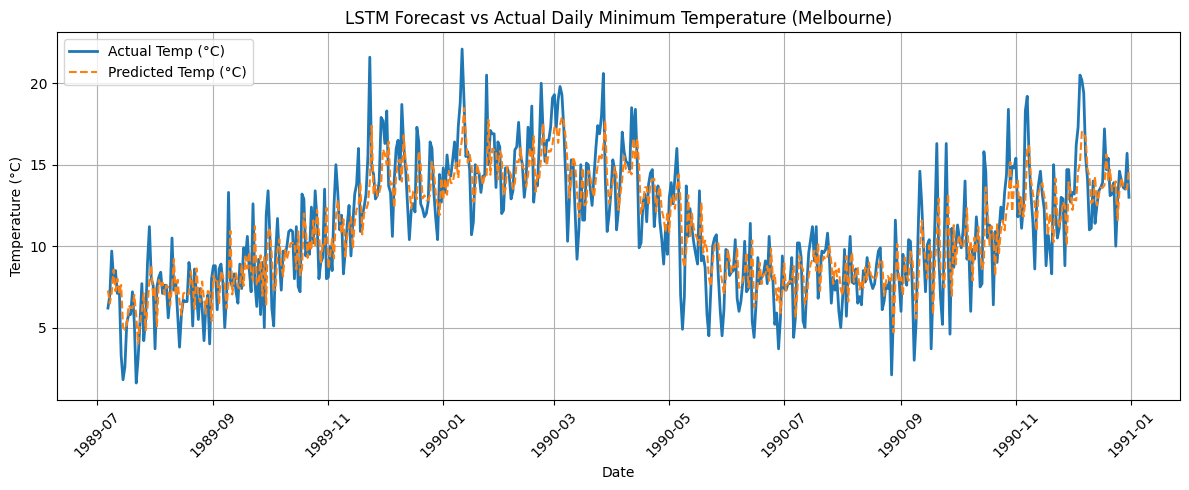

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# ----------------- INVERSE TRANSFORM -----------------
pred_real = test_preds  # Already inverse-transformed
actual_real = y_true    # Already inverse-transformed

# ----------------- DATE INDEXING -----------------
# Reconstruct test_dates from the original temperature DataFrame
# Assuming df is your original temperature DataFrame used in preprocessing
window_size = 30
total_sequences = len(df) - window_size
test_start_index = int(total_sequences * 0.85) + window_size  # +window_size accounts for initial shift
test_dates = df.index[test_start_index:test_start_index + len(y_test)]

# ----------------- PLOTTING -----------------
plt.figure(figsize=(12, 5))
plt.plot(test_dates, actual_real, label="Actual Temp (°C)", linewidth=2)
plt.plot(test_dates, pred_real, label="Predicted Temp (°C)", linestyle="--")
plt.title("LSTM Forecast vs Actual Daily Minimum Temperature (Melbourne)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------- SAVE TO CSV -----------------
results_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Temp (°C)": actual_real.flatten(),
    "LSTM Predicted Temp (°C)": pred_real.flatten()
})

results_df.to_csv("lstm_forecast_vs_actual_temperature.csv", index=False)


<h1>GRU for Melbourne Temperature Forecasting</h1>

GRU model:

- 2 GRU layers
- 64 hidden units
- Sequence length = 30
- MSE loss, Adam optimizer (learning rate = 0.001)
- Early stopping with patience = 10
- CPU execution

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ---------------- Prepare Temperature Data ----------------
X_train, y_train = X_train_temp, y_train_temp
X_val, y_val = X_val_temp, y_val_temp
X_test, y_test = X_test_temp, y_test_temp

# Reshape input: (samples, time_steps, features)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# ---------------- GRU Model ----------------
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])  # output at the final time step

model = GRUModel()

# ---------------- Training Setup ----------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
epochs = 100
patience = 10

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)

# ---------------- Training Loop with Early Stopping ----------------
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ---------------- Evaluation on Test Set ----------------
model.load_state_dict(best_model)
model.eval()
test_preds = model(X_test).detach().numpy()
y_true = y_test.numpy()

# Inverse transform before computing metrics
test_preds = scaler.inverse_transform(test_preds)
y_true = scaler.inverse_transform(y_true)

# Metrics
mse = mean_squared_error(y_true, test_preds)
mae = mean_absolute_error(y_true, test_preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - test_preds) / y_true)) * 100

# Print results
print("Test MSE (Temp-GRU):", mse)
print("Test MAE (Temp-GRU):", mae)
print("Test RMSE (Temp-GRU):", rmse)
print("Test MAPE (Temp-GRU):", mape, "%")


# GRU Forecast vs Actual Daily Minimum Temperature (Melbourne)

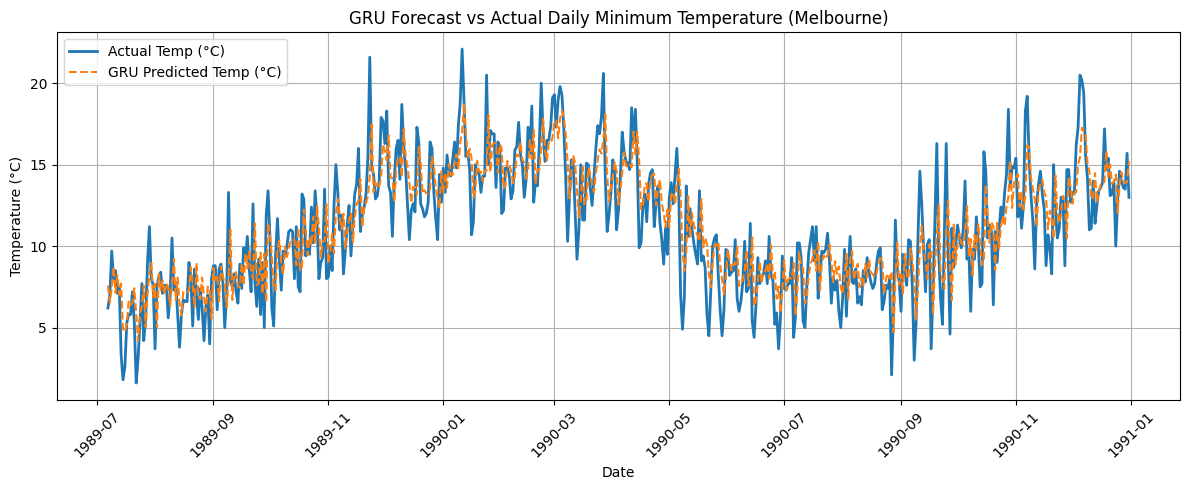

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --------- Already Inverse-Transformed Values ---------
pred_real = test_preds
actual_real = y_true

# --------- Rebuild Test Dates from Original Data ---------
window_size = 30
total_sequences = len(df) - window_size
start_idx = int(total_sequences * 0.85) + window_size
test_dates = df.index[start_idx:start_idx + len(y_test)]

# --------- Plot Forecast vs Actual ---------
plt.figure(figsize=(12, 5))
plt.plot(test_dates, actual_real, label="Actual Temp (°C)", linewidth=2)
plt.plot(test_dates, pred_real, label="GRU Predicted Temp (°C)", linestyle="--")
plt.title("GRU Forecast vs Actual Daily Minimum Temperature (Melbourne)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --------- Save Results to CSV ---------
results_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Temp (°C)": actual_real.flatten(),
    "GRU Predicted Temp (°C)": pred_real.flatten()
})
results_df.to_csv("gru_forecast_vs_actual_temperature.csv", index=False)


<h1>CNN for Melbourne Temperature Forecasting</h1>

CNN Model:
- 1D convolutional layers with kernel sizes of 3 and 5
- Followed by a fully connected layer to output the prediction
- Input length = 30 (1D sequences)
- MSE loss, Adam optimizer, early stopping, CPU-only execution

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ---------------- Prepare Temperature Data ----------------
X_train, y_train = X_train_temp, y_train_temp
X_val, y_val = X_val_temp, y_val_temp
X_test, y_test = X_test_temp, y_test_temp

# Reshape input for CNN: (samples, channels=1, sequence_length)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# ---------------- CNN Model ----------------
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

model = CNNModel()

# ---------------- Training Setup ----------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
epochs = 100
patience = 10

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)

# ---------------- Training Loop with Early Stopping ----------------
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ---------------- Evaluation on Test Set ----------------
model.load_state_dict(best_model)
model.eval()
test_preds = model(X_test).detach().numpy()
y_true = y_test.numpy()

# Inverse transform before computing metrics
test_preds = scaler.inverse_transform(test_preds)
y_true = scaler.inverse_transform(y_true)

# Metrics
mse = mean_squared_error(y_true, test_preds)
mae = mean_absolute_error(y_true, test_preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - test_preds) / y_true)) * 100

# Print results
print("Test MSE (Temp-CNN):", mse)
print("Test MAE (Temp-CNN):", mae)
print("Test RMSE (Temp-CNN):", rmse)
print("Test MAPE (Temp-CNN):", mape, "%")


# CNN Forecast vs Actual Daily Minimum Temperature (Melbourne)

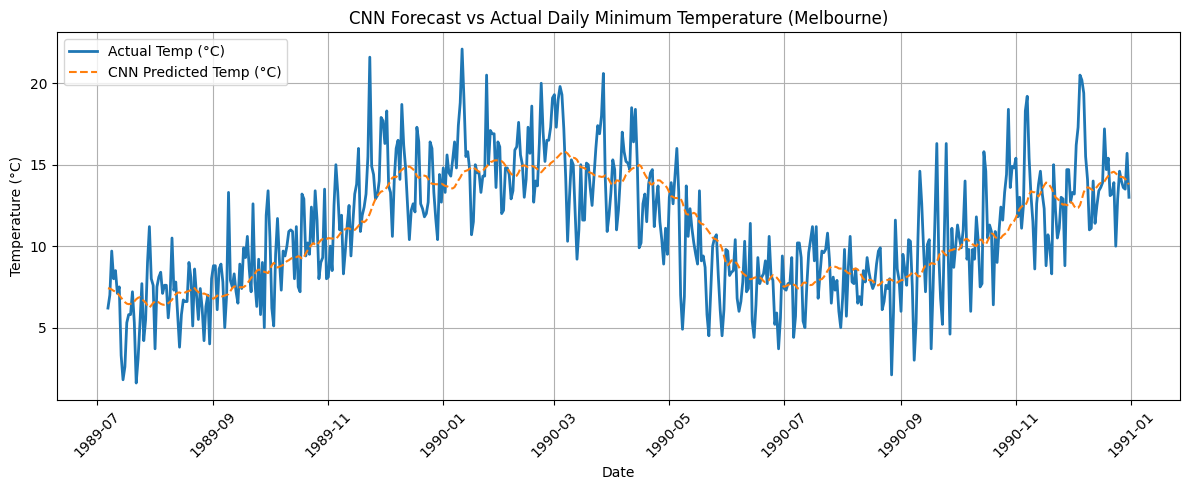

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --------- INVERSE TRANSFORMED VALUES (Already Done) ---------
pred_real = test_preds
actual_real = y_true

# --------- DATE INDEXING STEP ---------
# Assumes `df` is your original temperature DataFrame with datetime index
window_size = 30
total_sequences = len(df) - window_size
start_idx = int(total_sequences * 0.85) + window_size
test_dates = df.index[start_idx:start_idx + len(y_test)]

# --------- PLOT CNN RESULTS ---------
plt.figure(figsize=(12, 5))
plt.plot(test_dates, actual_real, label="Actual Temp (°C)", linewidth=2)
plt.plot(test_dates, pred_real, label="CNN Predicted Temp (°C)", linestyle="--")
plt.title("CNN Forecast vs Actual Daily Minimum Temperature (Melbourne)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --------- SAVE TO CSV ---------
results_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Temp (°C)": actual_real.flatten(),
    "CNN Predicted Temp (°C)": pred_real.flatten()
})

results_df.to_csv("cnn_forecast_vs_actual_temperature.csv", index=False)


<h1>Transformer for Melbourne Temperature Forecasting</h1>

Transformer Model:
- 2 encoder layers, 4 attention heads
- Feed-forward dimension = 128
- Input length = 30
- Includes positional encoding
- Trained using MSE loss, Adam optimizer, and early stopping

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import math

# ---------------- Prepare data ----------------
X_train, y_train = X_train_temp, y_train_temp
X_val, y_val = X_val_temp, y_val_temp
X_test, y_test = X_test_temp, y_test_temp

# Shape for Transformer: (sequence_length, batch_size, feature)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).transpose(0, 1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1).transpose(0, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).transpose(0, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# ---------------- Positional Encoding ----------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=30):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        for pos in range(max_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** (i / d_model)))
                if i + 1 < d_model:
                    pe[pos, i + 1] = math.cos(pos / (10000 ** (i / d_model)))
        self.pe = pe.unsqueeze(1)

    def forward(self, x):
        return x + self.pe[:x.size(0)]

# ---------------- Transformer Model ----------------
class TransformerModel(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, dim_feedforward=128):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        out = x[-1, :, :]  # use last time step's encoding
        return self.fc(out)

model = TransformerModel()

# ---------------- Training Setup ----------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
epochs = 100
patience = 10

train_loader = DataLoader(TensorDataset(X_train.transpose(0, 1), y_train), batch_size=batch_size, shuffle=False)

# ---------------- Training Loop with Early Stopping ----------------
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        xb = xb.transpose(0, 1)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val).detach()
        val_loss = criterion(val_preds, y_val).item()
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# ---------------- Evaluation on Test Set ----------------
model.load_state_dict(best_model)
model.eval()
test_preds = model(X_test).detach().numpy()
y_true = y_test.numpy()

# Inverse transform before computing metrics
test_preds = scaler.inverse_transform(test_preds)
y_true = scaler.inverse_transform(y_true)

# Metrics
mse = mean_squared_error(y_true, test_preds)
mae = mean_absolute_error(y_true, test_preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - test_preds) / y_true)) * 100

# Print results
print("Test MSE (Temp-Transformer):", mse)
print("Test MAE (Temp-Transformer):", mae)
print("Test RMSE (Temp-Transformer):", rmse)
print("Test MAPE (Temp-Transformer):", mape, "%")


# Transformer Forecast vs Actual Daily Minimum Temperature (Melbourne)

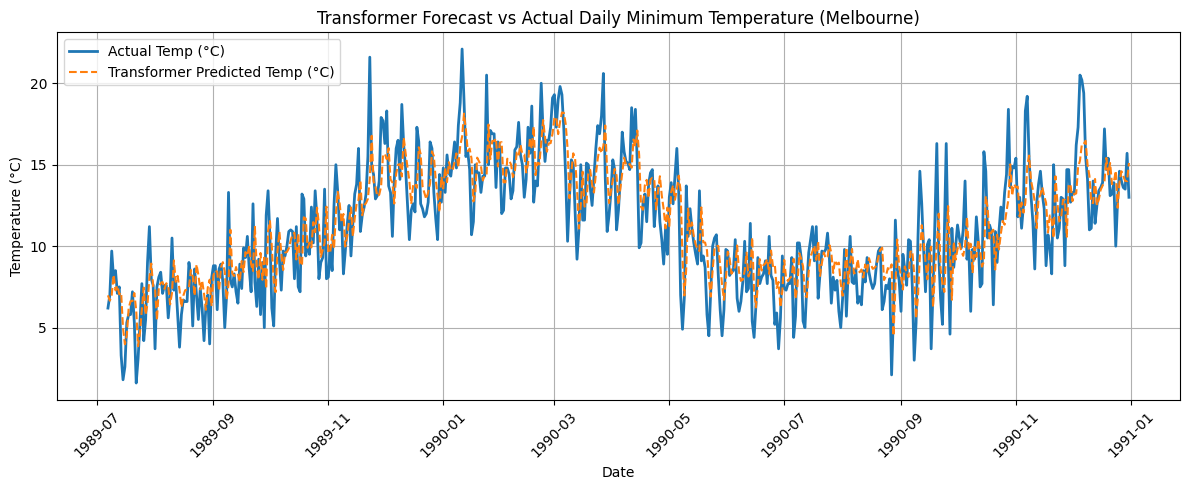

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --------- INVERSE TRANSFORMED VALUES ---------
pred_real = test_preds  # already inverse-transformed
actual_real = y_true    # already inverse-transformed

# --------- DATE INDEXING STEP ---------
# Assuming df is your original temperature DataFrame with datetime index
window_size = 30
total_sequences = len(df) - window_size
start_idx = int(total_sequences * 0.85) + window_size
test_dates = df.index[start_idx:start_idx + len(actual_real)]

# --------- PLOT ---------
plt.figure(figsize=(12, 5))
plt.plot(test_dates, actual_real, label="Actual Temp (°C)", linewidth=2)
plt.plot(test_dates, pred_real, label="Transformer Predicted Temp (°C)", linestyle="--")
plt.title("Transformer Forecast vs Actual Daily Minimum Temperature (Melbourne)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --------- SAVE TO CSV ---------
comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Temp (°C)": actual_real.flatten(),
    "Transformer Predicted Temp (°C)": pred_real.flatten()
})
comparison_df.to_csv("transformer_forecast_vs_actual_temperature.csv", index=False)


##############################################################################

# Common Plots

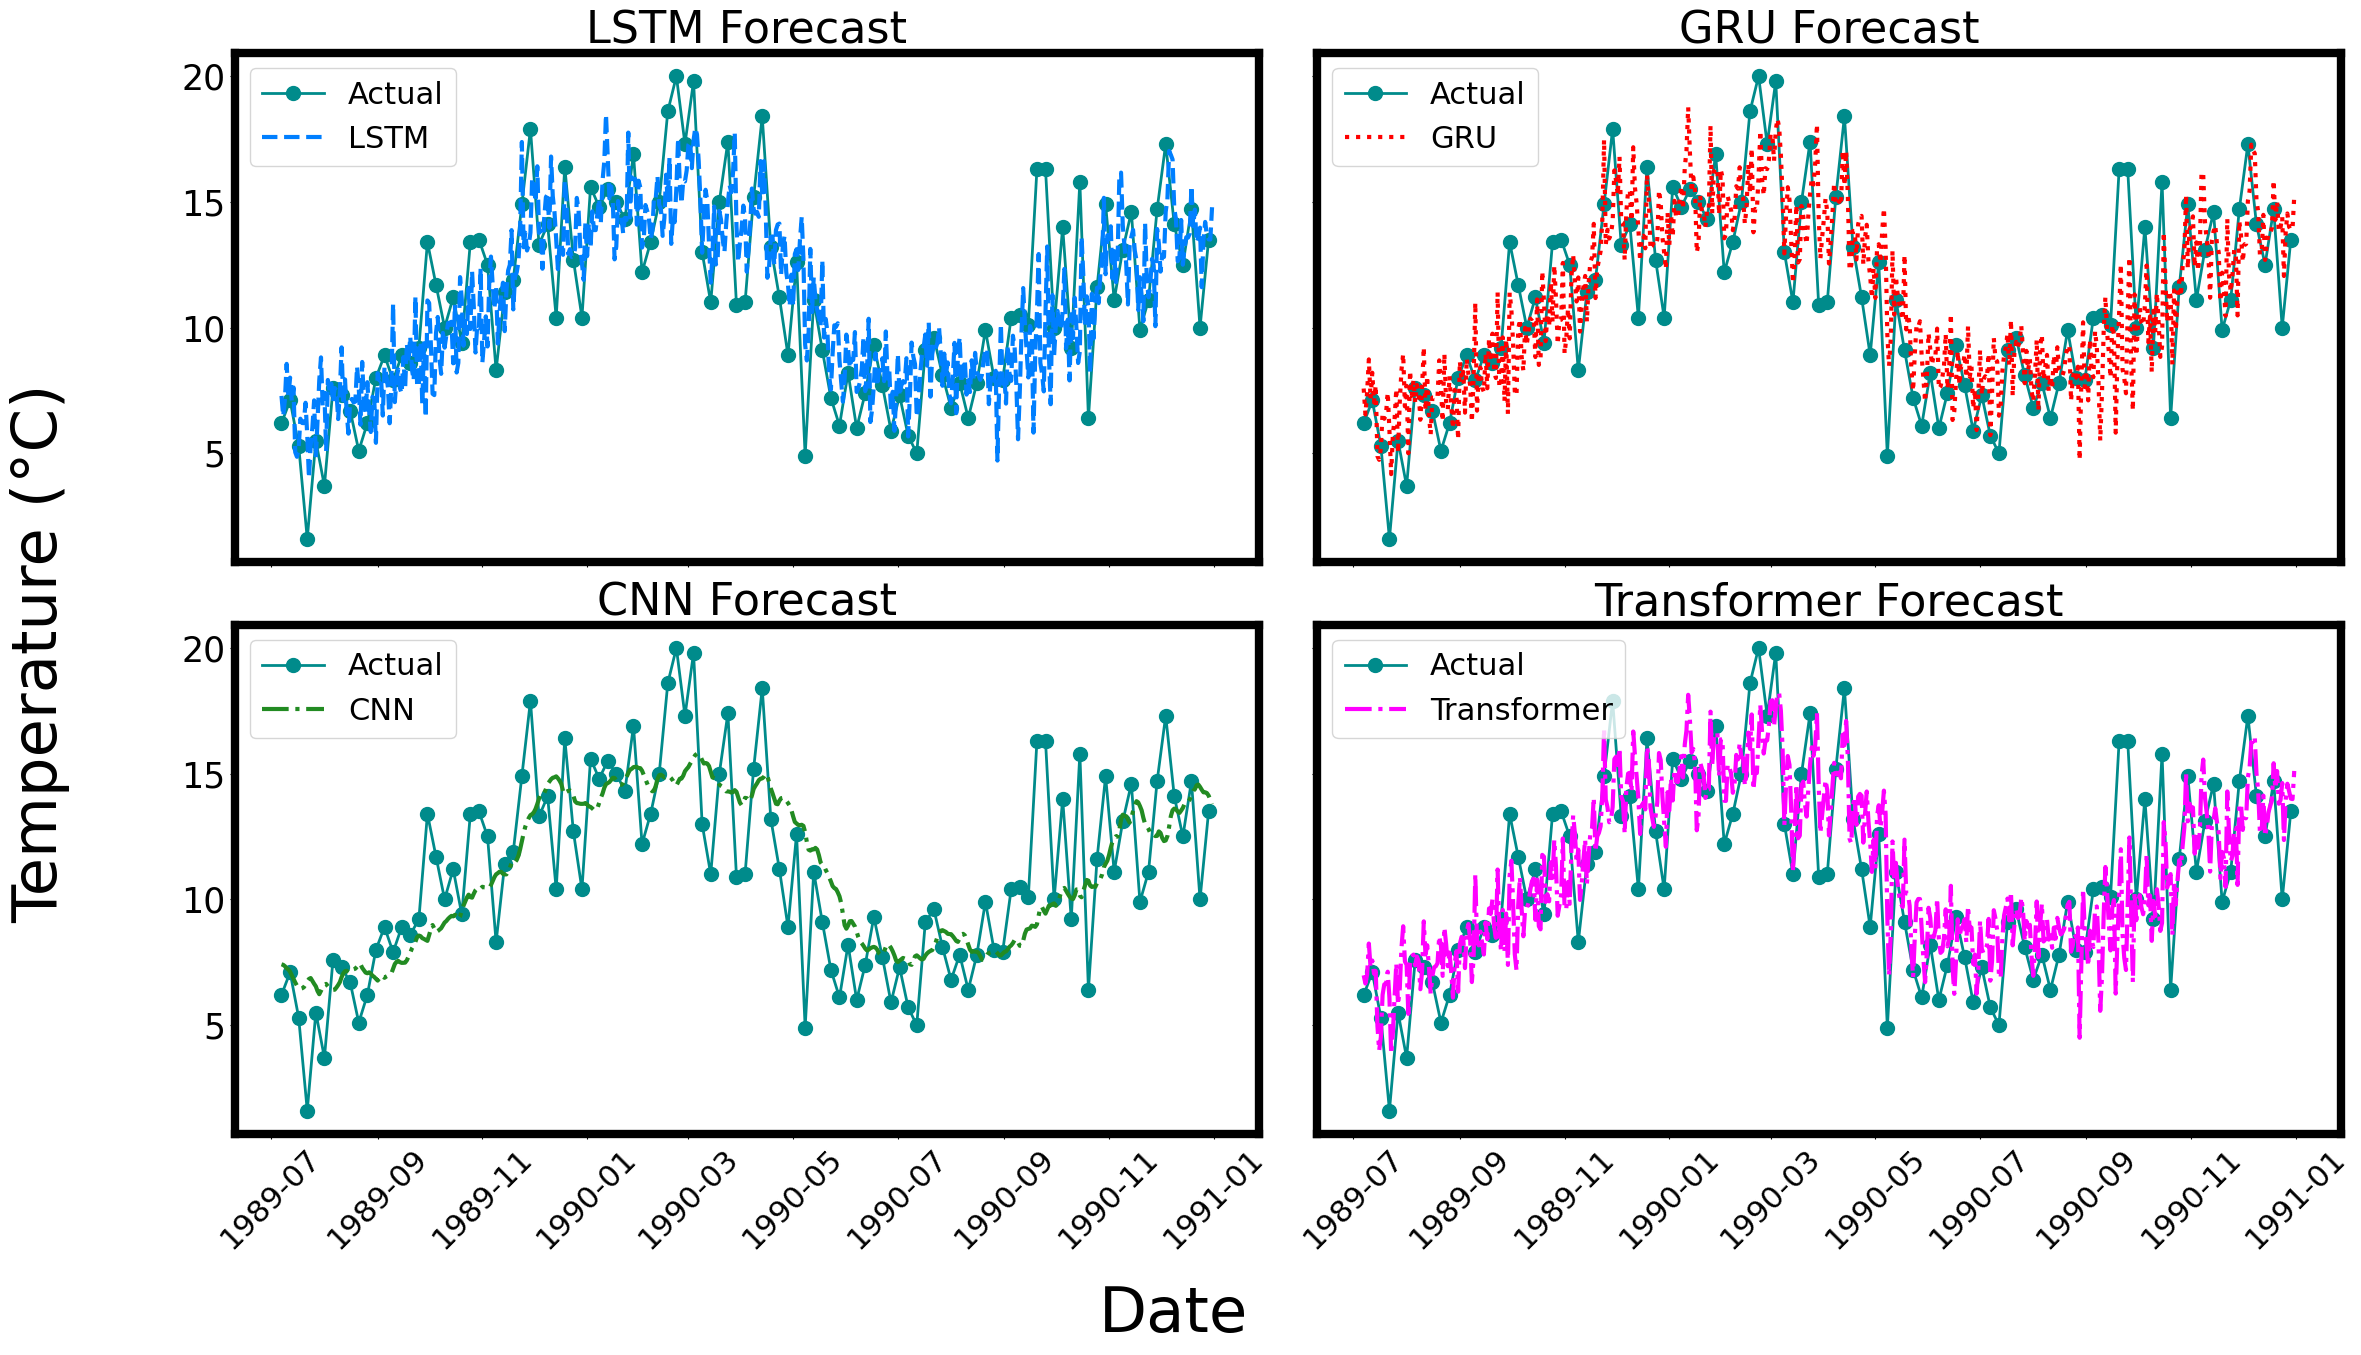

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --------- Load and rename columns ---------
df_lstm = pd.read_csv("lstm_forecast_vs_actual_temperature.csv")
df_gru = pd.read_csv("gru_forecast_vs_actual_temperature.csv")
df_cnn = pd.read_csv("cnn_forecast_vs_actual_temperature.csv")
df_trans = pd.read_csv("transformer_forecast_vs_actual_temperature.csv")

df_lstm.rename(columns={"LSTM Predicted Temp (°C)": "LSTM Predicted Temp (°C)"}, inplace=True)
df_gru.rename(columns={"GRU Predicted Temp (°C)": "GRU Predicted Temp (°C)"}, inplace=True)
df_cnn.rename(columns={"CNN Predicted Temp (°C)": "CNN Predicted Temp (°C)"}, inplace=True)
df_trans.rename(columns={"Transformer Predicted Temp (°C)": "Transformer Predicted Temp (°C)"}, inplace=True)

# --------- Convert date columns ---------
for df in [df_lstm, df_gru, df_cnn, df_trans]:
    df["Date"] = pd.to_datetime(df["Date"])

# --------- Downsample actual values for visibility ---------
step = 5
df_lstm_sparse = df_lstm[::step]
df_gru_sparse = df_gru[::step]
df_cnn_sparse = df_cnn[::step]
df_trans_sparse = df_trans[::step]

# --------- Create Subplots (2x2) ---------
fig, axes = plt.subplots(2, 2, figsize=(24, 14), sharex=True, sharey=True)
model_data = [
    ("LSTM", df_lstm, df_lstm_sparse, "#007FFF", '--'),
    ("GRU", df_gru, df_gru_sparse, "red", ':'),
    ("CNN", df_cnn, df_cnn_sparse, "forestgreen", '-.'),
    ("Transformer", df_trans, df_trans_sparse, "magenta", '-.'),
]

# --------- Plot each model subplot ---------
for ax, (label, df_full, df_sparse, color, style) in zip(axes.flat, model_data):
    # Plot actual with markers
    ax.plot(df_sparse["Date"], df_sparse["Actual Temp (°C)"], label="Actual", color="#008B8B",
            linestyle='solid', linewidth=2, marker='o', markersize=10)

    # Plot predictions
    ax.plot(df_full["Date"], df_full[f"{label} Predicted Temp (°C)"],
            label=f"{label}", color=color, linestyle=style, linewidth=3)

    # Axis formatting
    ax.set_title(f"{label} Forecast", fontsize=32)
    ax.tick_params(axis='x', labelrotation=45, labelsize=22)
    ax.tick_params(axis='y', labelsize=25)
    ax.grid(False)

    # Thicken plot border
    for spine in ax.spines.values():
        spine.set_linewidth(6)

    # Legend position
    ax.legend(fontsize=22, loc='upper left')

# --------- Shared axis labels ---------
fig.text(0.5, 0.015, 'Date', ha='center', fontsize=45)
fig.text(0.015, 0.5, 'Temperature (°C)', va='center', rotation='vertical', fontsize=45)

# --------- Layout adjustment ---------
plt.tight_layout(rect=[0.08, 0.06, 1, 0.97])

# --------- Save or show ---------
plt.savefig("forecast_comparison_subplots_temperature_styled.png", dpi=300)
plt.show()
